
# Sprint 3 - Modelamiento y evaluacion (Car Evaluation)
Modelos de clasificacion sobre el dataset Car Evaluation (UCI). Objetivo: predecir `class` (`unacc`, `acc`, `good`, `vgood`).


In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
import joblib

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)



## Carga y split de datos


In [2]:

col_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv("car+evaluation/car.data", names=col_names)
feature_cols = col_names[:-1]
X = df[feature_cols]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(handle_unknown="ignore"), feature_cols)],
    remainder="drop",
)



## Modelos candidatos
- Regresion Logistica
- Decision Tree
- Random Forest
- Linear SVM (hinge loss); para ROC-AUC se usa decision_function


In [3]:

models = {
    "log_reg": LogisticRegression(max_iter=2000, multi_class="auto"),
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "linear_svm": LinearSVC(random_state=42),
}



## Validacion cruzada (accuracy) en train


In [4]:

cv_rows = []
for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model),
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
    cv_rows.append({
        "model": name,
        "cv_mean": scores.mean(),
        "cv_std": scores.std(),
    })

cv_df = pd.DataFrame(cv_rows).sort_values(by="cv_mean", ascending=False)
cv_df


C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_mo

,model,cv_mean,cv_std
1,decision_tree,0.964535,0.007417
2,random_forest,0.945720,0.008000
0,log_reg,0.899424,0.015057
3,linear_svm,0.887127,0.015556



## Entrenamiento y evaluacion en test
- Se entrena cada modelo completo y se evalua en holdout.
- Metricas: Accuracy, Precision macro, Recall macro, F1 macro, ROC-AUC OVO macro.


In [5]:

results = []
conf_matrices = {}
reports = {}

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )

    # ROC-AUC macro one-vs-one (cuando el modelo expone decision_function o predict_proba)
    try:
        scores = pipe.decision_function(X_test)
        roc = roc_auc_score(y_test, scores, multi_class="ovo")
    except Exception:
        # LinearSVC con decision_function funciona; algunos pueden no soportarlo
        try:
            proba = pipe.predict_proba(X_test)
            roc = roc_auc_score(y_test, proba, multi_class="ovo")
        except Exception:
            roc = np.nan

    results.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "roc_auc_ovo": roc,
    })

    conf_matrices[name] = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
    reports[name] = classification_report(y_test, y_pred, digits=3)

results_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)
results_df


C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_ovo
2,random_forest,0.979769,0.982300,0.953319,0.967006,0.995919
1,decision_tree,0.973988,0.954533,0.941025,0.945033,0.960683
0,log_reg,0.901734,0.803379,0.775293,0.787257,0.977382
3,linear_svm,0.881503,0.815708,0.674019,0.723776,NaN



## Reporte del mejor modelo y matriz de confusion


Mejor modelo segun accuracy: random_forest

Classification report:

              precision    recall  f1-score   support

         acc      0.938     0.974     0.955        77
        good      1.000     0.929     0.963        14
       unacc      0.992     0.988     0.990       242
       vgood      1.000     0.923     0.960        13

    accuracy                          0.980       346
   macro avg      0.982     0.953     0.967       346
weighted avg      0.980     0.980     0.980       346

Matriz de confusion:
        acc  good  unacc  vgood
acc     75     0      2      0
good     1    13      0      0
unacc    3     0    239      0
vgood    1     0      0     12


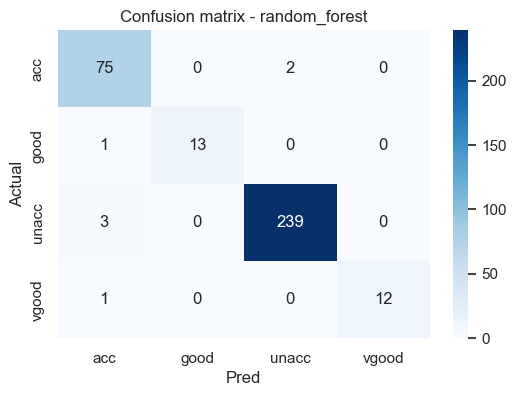

In [6]:
best_name = results_df.iloc[0]["model"]
print(f"Mejor modelo segun accuracy: {best_name}\n")
print("Classification report:\n")
print(reports[best_name])

cm = conf_matrices[best_name]
classes = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("Matriz de confusion:\n", cm_df)

sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion matrix - {best_name}")
plt.ylabel("Actual")
plt.xlabel("Pred")
plt.show()


## Guardado del mejor pipeline


In [7]:

# Entrenamos de nuevo el mejor modelo en todo el dataset para dejarlo listo.
best_model = models[best_name]
best_pipe = Pipeline([
    ("prep", preprocess),
    ("model", best_model),
])
best_pipe.fit(X, y)
joblib.dump(best_pipe, "best_car_model_sprint3.pkl")


['best_car_model_sprint3.pkl']


## Conclusiones rapidas
- La comparacion de accuracies y F1 macro permite ver si algun modelo sobreajusta o favorece clases mayoritarias.
- El ROC-AUC OVO puede no aplicarse a todos (se marca NaN cuando no se soporta).
- Guardamos el pipeline completo para su uso en el despliegue.
